### Part I: Construct LSH Hash Tables for All Documents

#### (a) Report the number of documents, and the number of features.

In [1]:
import pandas as pd
import numpy as np
import random as rm
from matplotlib import pyplot as plt
import seaborn as sns


df_all=pd.read_csv("cora_all",sep='\t',header=None)
df_query=pd.read_csv("cora_query",sep='\t',header=None)
df_all.head()

0     1     2     3     4     5     6     7     8     9     ...  1425  \
0    31336     0     0     0     0     0     0     0     0     0  ...     0   
1  1061127     0     0     0     0     0     0     0     0     0  ...     0   
2  1106406     0     0     0     0     0     0     0     0     0  ...     0   
3    13195     0     0     0     0     0     0     0     0     0  ...     0   
4    37879     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  
3     0     0     0     0     0     0     0     0  Reinforcement_Learning  
4     0     0     0     0     0     0     0     0   Probabilistic_Methods  

[5 rows x 1435 columns]

In [2]:
documents_df=df_all.shape[0]
features_df=df_all.shape[1]-2

# drop index
# df = df_all.iloc[: , 1:]
# df=df.to_numpy()
df=df_all.to_numpy()
df_q=df_query.to_numpy()

print("documents",documents_df)
print("features",features_df)

documents 2708
features 1433


In [3]:
PRIME_NUMBER=9973
# create a list which include each features from 0 to 1433
features_list=list(range(0, features_df))
column_name=['paper_id','jaccard_sim','class_label']


# create a primes list

def primesInRange(x, y):
    prime_list = []
    for n in range(x, y):
        isPrime = True
        for num in range(2, n):
            if n % num == 0:
                isPrime = False
        if isPrime:
            prime_list.append(n)
    return prime_list
prime_list = primesInRange(3,PRIME_NUMBER)



#build the permutation  list
def permutation(l,k):
    perm_list=[]
    i=0
    while(i<l):
        hash_list=[]
        j=0
        while(j<k):
            hash_value_list=[]
            for f in features_list:
                hash_value = hash_function(f)
                hash_value_list.append(hash_value)
            hash_list.append(hash_value_list)
            j=j+1
        i=i+1
        perm_list.append(hash_list)
    return perm_list


# build a hash value randomly according a big  permutation
def hash_function(x):
    random_prime_a = rm.choice(prime_list)
    random_prime_b = rm.choice(prime_list)
    hash_value = (random_prime_a*x+random_prime_b)%PRIME_NUMBER%features_df
    return hash_value

# save hash list into buckes
def LSH_function(l,k,min_signature,data):
#     create a empty table which same with our array
    lsh= np.empty(shape=(l, documents_df),dtype=object)
    for index_min,value_min in enumerate(min_signature):
        random_list = np.random.randint(0, PRIME_NUMBER, k)
        for index_data, value_data in enumerate(np.array(value_min).T):
            random_value=np.dot(value_data, random_list)
            buckets = random_value % PRIME_NUMBER % documents_df
            id_data = data[index_data][0]
            if not lsh[index_min][buckets]:
                lsh[index_min][buckets]=[]
                lsh[index_min][buckets].append(id_data)
            else:
                lsh[index_min][buckets].append(id_data)
    return lsh

# build Min Signatures matrix
def min_signature_function(l,k,matrix_perm,data):
    min_signature_list=[]
    i=0
    while(i<l):      
        hash_list = []
        j=0
        while(j<k):
            hash_value_list=[]
            for datas in data: 
#                 drop first column
                data_feature = datas[1:-1]
                min_value = PRIME_NUMBER
                target_prime = matrix_perm[i][j]
                for index, text in enumerate(data_feature):
                    if text == 1:
                        if target_prime[index]< min_value:
                            min_value = target_prime[index]
                hash_value_list.append(min_value)
#                 save min permutation
            hash_list.append(hash_value_list)
            j=j+1
        i=i+1
        min_signature_list.append(hash_list)
    return min_signature_list

# find the similarity of lsh table 
def find_similarity_lsh(Lsh,df_q):
    similar_list = []
    for ids in df_q.T[0]:
        same_value = [ids]
        for i in Lsh:
            for j in i:
                if j is not None:
                    if ids in j:
#                         find same document bewteen two list
                        same_value.extend(j)
        same_value = list(dict.fromkeys(same_value))
#         drop same one value 
        similar_list.append(same_value)
    return similar_list    

# find the document labe for class_label in Jaccard list
def class_label_function(documents,ids):
    for document in documents:
        if document[0] == ids:
            return document[-1]
        
# accoring teh id find document in Jaccard list
def find_documents(ids,data):
    documents_min_list = []
    data_index = 0
    for index_all, text in enumerate(df):
        if text[0] == ids:
            data_index = index_all
            break
    for i in data:
        documents_min_value = np.array(i).T[data_index]
        documents_min_list.extend(documents_min_value)
    return documents_min_list





def jaccard_function(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))



def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity



def LSH_table_similary_a(Lsh_similar,min_signature,top=None):
    #for each query doc, find the n similarest doc
    similar_LSH_summary_a=[]
    for ids in Lsh_similar:
        query_Id = ids[0]
        jaccard_list = {}
        jaccard_list['paper_id'] = []
        jaccard_list['jaccard_sim'] = []
        jaccard_list['class_label'] =[]
        for i in ids:
            jaccard_list['paper_id'].append(i)
            query_documents = find_documents(query_Id,min_signature)
            all_documents = find_documents(i,min_signature)
            jaccard_sim = jaccard_function(query_documents,all_documents)
            jaccard_list['jaccard_sim'].append(jaccard_sim)
            class_label= class_label_function(df,i)
            jaccard_list['class_label'].append(class_label)
        jaccard_list = pd.DataFrame(data=jaccard_list, columns=column_name)
        jaccard_list = jaccard_list.sort_values(by=['jaccard_sim'],ascending=False)      
        if top is not None:
            jaccard_list = jaccard_list.iloc[:top]
        similar_LSH_summary_a.append(jaccard_list)
    return similar_LSH_summary_a

# not include first columns
def find_documents_2(documents,ids):
    for document in documents:
        if document[0] == ids:
            return document[1:-1]

def LSH_table_similary_b(df_all,df_q,top=None):
    similar_LSH_summary_b=[]
    All_ids = df_all[:,:1]
    query_ids = df_q[:,:1]

    for query_id in query_ids:
#         build a empty jaccard_list
        query_documents = find_documents_2(df_q,query_id)
        jaccard_list = {}
        jaccard_list["paper_id"] = []
        jaccard_list["jaccard_sim"] = []
        jaccard_list["class_label"] =[]
#         save value into jaccard_list
        for All_id in All_ids:
            jaccard_list["paper_id"].append(All_id)
            all_documents = find_documents_2(df_all,All_id)
            jaccard_sim = jaccard_binary(query_documents,all_documents)
            jaccard_list["jaccard_sim"].append(jaccard_sim)
            class_label= class_label_function(df_all,All_id)
            jaccard_list["class_label"].append(class_label)
        jaccard_list = pd.DataFrame(data=jaccard_list, columns=column_name)
        jaccard_list = jaccard_list.sort_values(by=['jaccard_sim'],ascending=False)
        if top is not None:
            jaccard_list = jaccard_list.iloc[:top]
        similar_LSH_summary_b.append(jaccard_list)
    return similar_LSH_summary_b       

def MRR(a,b):
    score=0;mrr_q=0;
    for index, value in enumerate(a):
        sum_q = 0
        for i, query in value.iterrows():
            id = query["paper_id"]
            nth = b[index].loc[b[index]['paper_id']==id].index[0]+1
            sum_q += (1/nth)
        mrr_q = sum_q/len(value)
        score += mrr_q
    score=score/len(a)
    return score

#### (b) Report the logic of your hash functions in mathematical equation.


In [4]:
perm_list=permutation(20,10)
pd.DataFrame(data=perm_list)


0  \
0   [1104, 213, 1073, 628, 1281, 1417, 707, 1112, ...   
1   [11, 866, 491, 3, 849, 164, 1167, 43, 621, 141...   
2   [1235, 509, 71, 538, 44, 1197, 1379, 682, 520,...   
3   [434, 736, 802, 368, 17, 864, 1302, 162, 836, ...   
4   [789, 513, 293, 97, 179, 197, 406, 1029, 776, ...   
5   [82, 86, 204, 838, 348, 261, 772, 405, 698, 68...   
6   [1230, 743, 145, 1388, 1157, 910, 1072, 324, 8...   
7   [493, 575, 1395, 990, 339, 1321, 477, 801, 408...   
8   [1138, 270, 665, 1284, 991, 1081, 181, 650, 46...   
9   [594, 719, 671, 558, 87, 294, 1295, 870, 687, ...   
10  [873, 1284, 857, 1064, 646, 1197, 653, 962, 10...   
11  [43, 882, 792, 618, 1284, 682, 1134, 665, 963,...   
12  [693, 1021, 960, 454, 218, 725, 867, 1253, 997...   
13  [747, 483, 495, 1104, 195, 796, 799, 789, 389,...   
14  [1325, 470, 667, 203, 1113, 1168, 65, 1125, 12...   
15  [1151, 1397, 1065, 1039, 95, 437, 65, 720, 128...   
16  [61, 685, 904, 1326, 1017, 394, 645, 50, 928, ...   
17  [312, 740, 1220, 642, 614, 725, 1083, 844, 184...   
18  [606, 638, 335, 1105, 239, 539, 1226, 722, 994...   
19  [683, 241, 789, 449, 394, 1043, 750, 374, 51, ...   

                                                    1  \
0   [1184, 264, 442, 480, 992, 980, 27, 229, 1059,...   
1   [1013, 1017, 983, 1394, 1291, 1292, 480, 785, ...   
2   [819, 652, 973, 196, 375, 948, 1025, 393, 962,...   
3   [797, 622, 534, 283, 416, 1018, 131, 608, 923,...   
4   [962, 1208, 878, 699, 322, 1186, 1205, 230, 13...   
5   [1116, 1265, 1258, 878, 570, 245, 1397, 115, 6...   
6   [246, 702, 1202, 976, 28, 1245, 919, 1419, 780...   
7   [1337, 686, 1032, 619, 980, 506, 463, 959, 893...   
8   [1363, 264, 795, 117, 917, 710, 980, 1369, 870...   
9   [484, 226, 795, 26, 816, 626, 15, 939, 1013, 7...   
10  [1259, 1344, 897, 515, 1281, 1364, 262, 1239, ...   
11  [1267, 274, 1331, 83, 1412, 1015, 865, 512, 12...   
12  [471, 660, 260, 405, 375, 648, 1066, 1126, 89,...   
13  [1068, 1232, 441, 514, 667, 564, 1125, 13, 136...   
14  [631, 983, 1401, 166, 694, 1345, 306, 636, 349...   
15  [229, 1073, 1126, 475, 166, 1248, 1043, 68, 79...   
16  [957, 991, 304, 1414, 440, 119, 646, 1152, 513...   
17  [271, 475, 171, 522, 132, 557, 251, 870, 1363,...   
18  [175, 195, 1167, 74, 195, 333, 609, 968, 399, ...   
19  [1024, 28, 579, 1351, 415, 828, 891, 597, 857,...   

                                                    2  \
0   [71, 537, 946, 131, 803, 361, 337, 132, 682, 1...   
1   [525, 595, 1046, 1413, 509, 248, 912, 634, 117...   
2   [1185, 1406, 645, 1371, 62, 930, 982, 888, 311...   
3   [397, 274, 466, 1352, 69, 479, 650, 31, 924, 5...   
4   [1354, 891, 165, 1154, 979, 197, 1328, 118, 72...   
5   [1198, 81, 1276, 968, 330, 623, 878, 952, 961,...   
6   [789, 418, 116, 1232, 211, 1306, 1140, 807, 53...   
7   [1293, 1144, 642, 185, 122, 72, 726, 164, 157,...   
8   [146, 1264, 770, 732, 1291, 1147, 798, 189, 93...   
9   [914, 175, 1165, 753, 831, 1041, 838, 273, 952...   
10  [1201, 940, 993, 1401, 947, 1287, 1188, 515, 5...   
11  [277, 125, 233, 54, 1335, 382, 710, 823, 351, ...   
12  [719, 604, 338, 1030, 433, 132, 917, 953, 360,...   
13  [998, 101, 771, 756, 47, 479, 744, 301, 9, 377...   
14  [1183, 761, 1416, 247, 1268, 339, 591, 298, 63...   
15  [193, 1065, 1210, 544, 746, 651, 1200, 1111, 1...   
16  [109, 386, 841, 51, 1137, 1009, 823, 461, 2, 3...   
17  [606, 1206, 1324, 326, 454, 862, 1037, 51, 111...   
18  [350, 373, 546, 895, 509, 1387, 560, 368, 1020...   
19  [1233, 1033, 982, 546, 1046, 1102, 508, 1209, ...   

                                                    3  \
0   [583, 66, 464, 908, 61, 994, 38, 839, 1039, 73...   
1   [47, 915, 827, 1353, 1163, 1180, 43, 836, 540,...   
2   [1041, 646, 821, 1046, 1039, 190, 1298, 834, 1...   
3   [139, 1164, 1219, 430, 318, 11, 1308, 324, 39,...   
4   [1014, 133, 943, 372, 979, 1176, 687, 1236, 53...   
5   [101, 892, 763, 51, 253, 106, 1050, 317, 472, ...   
6   [505, 424, 1366, 1148, 770, 1189, 867, 1025, 3...   
7 

#### c) Report one table with all documents hashed into one hash table of your choice using heatmap plot.


In [5]:
min_signature_list=min_signature_function(20,10,perm_list,df)
pd.DataFrame(data=min_signature_list)


0  \
0   [68, 46, 70, 41, 77, 141, 82, 41, 230, 43, 42,...   
1   [77, 2, 16, 15, 37, 53, 10, 3, 77, 163, 165, 9...   
2   [75, 105, 59, 97, 38, 4, 39, 10, 75, 86, 198, ...   
3   [41, 39, 39, 81, 34, 81, 32, 57, 459, 2, 240, ...   
4   [109, 49, 24, 55, 141, 82, 39, 97, 95, 24, 95,...   
5   [1, 43, 60, 14, 24, 218, 43, 147, 113, 113, 10...   
6   [99, 9, 71, 185, 99, 50, 9, 14, 181, 87, 139, ...   
7   [102, 62, 8, 140, 5, 48, 171, 296, 263, 55, 72...   
8   [138, 5, 2, 1, 144, 340, 79, 427, 23, 33, 13, ...   
9   [9, 133, 19, 183, 78, 24, 207, 109, 375, 52, 8...   
10  [89, 125, 1, 21, 89, 354, 58, 16, 526, 49, 12,...   
11  [12, 61, 78, 85, 72, 58, 3, 256, 72, 60, 72, 3...   
12  [29, 81, 59, 6, 3, 87, 27, 47, 29, 45, 110, 11...   
13  [13, 17, 21, 78, 174, 9, 341, 79, 96, 180, 20,...   
14  [4, 177, 29, 51, 49, 3, 49, 82, 235, 49, 235, ...   
15  [75, 61, 151, 61, 24, 119, 101, 41, 75, 9, 209...   
16  [47, 112, 10, 19, 47, 87, 111, 121, 47, 47, 47...   
17  [172, 13, 15, 62, 13, 62, 94, 17, 413, 272, 14...   
18  [48, 95, 30, 1, 48, 7, 13, 70, 696, 51, 371, 9...   
19  [25, 33, 41, 41, 41, 41, 41, 41, 25, 75, 190, ...   

                                                    1  \
0   [14, 19, 31, 59, 14, 88, 74, 194, 14, 14, 14, ...   
1   [4, 18, 18, 59, 9, 70, 18, 18, 59, 18, 550, 18...   
2   [299, 83, 70, 6, 64, 124, 132, 29, 553, 29, 17...   
3   [36, 171, 51, 170, 144, 1, 124, 13, 173, 46, 1...   
4   [88, 4, 65, 12, 6, 59, 27, 9, 230, 9, 341, 107...   
5   [84, 87, 120, 1, 138, 145, 35, 176, 84, 40, 53...   
6   [0, 46, 5, 111, 21, 41, 41, 111, 29, 46, 99, 4...   
7   [45, 214, 25, 122, 62, 119, 179, 50, 97, 97, 9...   
8   [26, 74, 25, 130, 56, 30, 58, 26, 106, 26, 256...   
9   [154, 16, 181, 30, 40, 98, 110, 26, 154, 181, ...   
10  [97, 8, 14, 14, 14, 14, 14, 14, 328, 45, 333, ...   
11  [40, 64, 75, 168, 60, 281, 60, 9, 148, 22, 148...   
12  [17, 22, 321, 31, 15, 313, 15, 144, 17, 17, 17...   
13  [29, 146, 20, 13, 78, 35, 21, 131, 578, 41, 17...   
14  [88, 216, 79, 46, 32, 17, 17, 39, 134, 68, 374...   
15  [29, 111, 3, 38, 97, 97, 64, 1, 652, 56, 237, ...   
16  [3, 2, 84, 9, 103, 150, 4, 9, 204, 109, 87, 20...   
17  [80, 83, 5, 26, 25, 88, 2, 42, 80, 47, 123, 36...   
18  [63, 146, 116, 127, 7, 141, 62, 22, 346, 146, ...   
19  [18, 141, 84, 57, 75, 81, 81, 15, 18, 41, 394,...   

                                                    2  \
0   [11, 20, 99, 5, 20, 135, 19, 64, 123, 75, 144,...   
1   [77, 105, 45, 65, 93, 77, 6, 17, 64, 42, 64, 1...   
2   [123, 251, 165, 38, 54, 204, 5, 62, 133, 40, 3...   
3   [81, 51, 15, 29, 197, 9, 54, 9, 81, 83, 397, 1...   
4   [189, 128, 19, 52, 97, 90, 75, 116, 189, 131, ...   
5   [144, 161, 90, 134, 33, 253, 70, 7, 144, 7, 39...   
6   [46, 116, 96, 42, 46, 116, 48, 109, 46, 46, 46...   
7   [4, 59, 53, 198, 1, 78, 90, 14, 4, 4, 4, 28, 4...   
8   [3, 48, 138, 205, 3, 33, 48, 241, 3, 3, 3, 96,...   
9   [62, 42, 11, 33, 25, 33, 159, 284, 105, 49, 52...   
10  [196, 2, 89, 58, 10, 34, 50, 225, 196, 11, 328...   
11  [25, 13, 13, 53, 1, 157, 91, 0, 25, 26, 333, 7...   
12  [34, 72, 7, 45, 45, 113, 112, 66, 266, 79, 427...   
13  [118, 42, 32, 16, 66, 367, 9, 16, 204, 86, 218...   
14  [171, 77, 142, 169, 7, 14, 9, 121, 388, 77, 20...   
15  [9, 111, 19, 96, 9, 42, 9, 106, 647, 78, 668, ...   
16  [225, 31, 30, 146, 79, 41, 130, 51, 304, 70, 3...   
17  [101, 80, 183, 40, 52, 15, 39, 326, 883, 6, 36...   
18  [43, 118, 56, 90, 91, 43, 168, 380, 692, 112, ...   
19  [101, 30, 46, 234, 5, 15, 115, 160, 457, 10, 2...   

                                                    3  \
0   [6, 185, 116, 32, 6, 32, 6, 13, 614, 124, 146,...   
1   [76, 11, 12, 37, 26, 124, 73, 10, 342, 102, 60...   
2   [100, 13, 244, 9, 3, 9, 27, 38, 527, 120, 125,...   
3   [27, 213, 41, 308, 44, 44, 235, 36, 141, 130, ...   
4   [30, 109, 135, 33, 7, 57, 64, 33, 257, 59, 637...   
5   [42, 183, 11, 42, 78, 61, 59, 51, 74, 80, 74, ...   
6   [8, 11, 10, 51, 16, 1, 283, 195, 8, 97, 31, 18...   
7 

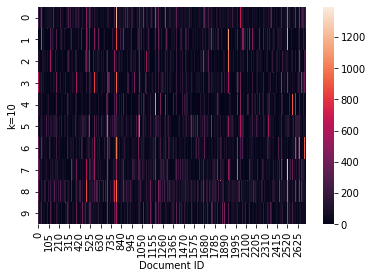

In [6]:
heatmap=sns.heatmap(min_signature_list[0])
plt.xlabel("Document ID") 
plt.ylabel("k=10") 
plt.show()

### Part II: Nearest Neighbor Search 

#### (a)Report the list of top-10 documents with highest Jaccard similarity in descending order for each query q.

In [7]:

Lsh_list=LSH_function(20,10,min_signature_list,df)
pd.DataFrame(data=Lsh_list)

0                     1                          2     \
0                      None             [1130780]                  [1112665]   
1                      None  [3828, 91852, 16451]               [22875, 164]   
2                      None               [78508]           [643003, 289885]   
3          [628500, 103543]    [1153900, 1113438]                       None   
4                  [469504]                  None  [168410, 270456, 1135345]   
5           [1131719, 6224]             [1129369]           [353541, 686015]   
6                  [521252]                  None                   [390896]   
7                      None                  None                       None   
8                    [8696]             [1154074]                       None   
9                   [45212]             [1152379]            [5462, 1104946]   
10                     None             [1132948]                       None   
11  [33904, 1114526, 36162]              [714208]                  [1131165]   
12                [1110256]         [6346, 27249]                  [1110028]   
13         [582343, 820661]      [91581, 1116397]            [235670, 62333]   
14                   [1034]                  None                   [193352]   
15                  [37884]                  None                       None   
16                [1125992]              [917493]                       None   
17                     None      [73119, 1115701]                       None   
18                [1112071]              [654339]             [62607, 74427]   
19                  [10430]               [40922]                  [1121398]   

                         3                          4     \
0   [1153577, 101811, 593559]                   [948299]   
1               [51934, 1213]                    [16843]   
2            [294145, 763181]   [123556, 187260, 177993]   
3                    [198653]                    [82920]   
4                     [11325]                       None   
5                    [154134]            [575292, 29723]   
6                        None                       None   
7                        None          [1120211, 107252]   
8                        None                     [5055]   
9                        None                       None   
10                       None                       None   
11                       None                    [32260]   
12                       None                   [854434]   
13                       None                       None   
14                       None  [1115291, 95586, 1134022]   
15                    [48766]  [1119708, 601462, 626531]   
16                       None                       None   
17      [33895, 18582, 31489]                    [40605]   
18                    [66596]                  [1131150]   
19                       None    [95435, 75983, 1106330]   

                                 5                                      6     \
0                                None                                   None   
1                                None  [3218, 362926, 11342, 593201, 118559]   
2                              [1365]                               [259701]   
3                            [179706]                              [1133338]   
4                           [1131611]                               [684986]   
5                             [12337]                                   None   
6                           [1106789]               [1130856, 263279, 78555]   
7                    [231198, 523010]     [1109439, 814836, 1050679, 375605]   
8   [1116530, 229635, 260979, 409725]                              [1119742]   
9                    [1131634, 36167]                                   None   
10                               None                                   None   
11                     [75972, 61312]                     [1135108, 1131172]   
12                           [289780]    

In [8]:
similar_lsh_list=find_similarity_lsh(Lsh_list,df_q)
pd.DataFrame(data=similar_lsh_list)

0       1       2        3        4        5        6        7   \
0    31336  334153   60682   753070  1135368    31489     1237  1132505   
1  1106406   74700    3084  1102550    63477    96847   219239  1059953   
2    37879  141171   13212    44455   180187   696343  1103315  1131335   
3   217139   31105  129558    51934    82920   134316   136665   566653   
4  1128990    3243  219239   160705   282700   108962  1103016  1153860   
5  1106418   16470  189856  1131330    40125  1120138    77108   431206   
6  1061127  522338  631052    75983   594011    12238   137873  1121063   

        8        9   ...       28       29         30        31       32  \
0  1114239   633081  ...      NaN      NaN        NaN       NaN      NaN   
1  1120059    25184  ...      NaN      NaN        NaN       NaN      NaN   
2    49482  1112723  ...      NaN      NaN        NaN       NaN      NaN   
3    37884    12359  ...  22566.0  12946.0  1107355.0  643069.0  81714.0   
4  1152761  1136397  ...      NaN      NaN        NaN       NaN      NaN   
5   159897    66990  ...      NaN      NaN        NaN       NaN      NaN   
6     3112   470511  ...      NaN      NaN        NaN       NaN      NaN   

          33       34       35        36         37  
0        NaN      NaN      NaN       NaN        NaN  
1        NaN      NaN      NaN       NaN        NaN  
2        NaN      NaN      NaN       NaN        NaN  
3  1128839.0  34266.0  25702.0  643597.0  1131149.0  
4        NaN      NaN      NaN       NaN        NaN  
5        NaN      NaN      NaN       NaN        NaN  
6        NaN      NaN      NaN       NaN        NaN  

[7 rows x 38 columns]

In [11]:
similar_LSH_summary_a=LSH_table_similary_a(similar_lsh_list,min_signature_list,10)
similar_LSH_summary_a

[    paper_id  jaccard_sim            class_label
 0      31336     1.000000        Neural_Networks
 7    1132505     0.503401        Neural_Networks
 17      1026     0.475000     Genetic_Algorithms
 9     633081     0.474359  Probabilistic_Methods
 19    154982     0.469799  Probabilistic_Methods
 4    1135368     0.469799        Neural_Networks
 12    340299     0.458333        Neural_Networks
 18     62389     0.456376             Case_Based
 8    1114239     0.445161     Genetic_Algorithms
 5      31489     0.433121  Probabilistic_Methods,
     paper_id  jaccard_sim             class_label
 0    1106406     1.000000  Reinforcement_Learning
 5      96847     0.543046      Genetic_Algorithms
 10    566664     0.496689              Case_Based
 7    1059953     0.486842                  Theory
 8    1120059     0.483871         Neural_Networks
 18    643221     0.480000   Probabilistic_Methods
 15     63931     0.466667           Rule_Learning
 6     219239     0.466258               

#### Part II (b) Report the list of top-10 documents with highest Jaccard similarity in descending order for each query q.

In [12]:
similar_LSH_summary_b=LSH_table_similary_b(df,df_q,10)
similar_LSH_summary_b

[      paper_id  jaccard_sim            class_label
 0      [31336]     1.000000        Neural_Networks
 14     [31353]     0.300000        Neural_Networks
 443   [686559]     0.225806        Neural_Networks
 8      [31349]     0.190476        Neural_Networks
 1924   [50381]     0.184211                 Theory
 258    [10531]     0.181818        Neural_Networks
 1437  [300071]     0.176471  Probabilistic_Methods
 1116   [35905]     0.161290        Neural_Networks
 613    [31927]     0.156250        Neural_Networks
 891   [446610]     0.151515  Probabilistic_Methods,
        paper_id  jaccard_sim             class_label
 2     [1106406]     1.000000  Reinforcement_Learning
 566      [6214]     0.181818  Reinforcement_Learning
 173    [124064]     0.170732  Reinforcement_Learning
 868     [28473]     0.162162  Reinforcement_Learning
 397   [1119140]     0.161290         Neural_Networks
 1979  [1105148]     0.157895  Reinforcement_Learning
 1998  [1132073]     0.156250         Neural_Netw

### Part III: Search Quality Evaluation

#### Part III (a) Report an MRR plot with a varying number of tables l=[20,40,60,80].

In [5]:
def Search_Quality_Evaluation(l,k):
    perm_list=permutation(l,k)
    min_signature_list=min_signature_function(l,k,perm_list,df)
    Lsh_list=LSH_function(l,k,min_signature_list,df)
    similar_lsh_list=find_similarity_lsh(Lsh_list,df_q)
    a=LSH_table_similary_a(similar_lsh_list,min_signature_list,10)
    b=LSH_table_similary_b(df,df_q)
    return MRR(a,b)

In [14]:
l_table=[20,40,60,80]
MRR_list_a=[]
for l in l_table:
    MRR_list_a.append(Search_Quality_Evaluation(l,10))
    print("..",l,"%")
MRR_list_a

.. 20 %
.. 40 %
.. 60 %
.. 80 %


[0.03451133830164753,
 0.03418013349680435,
 0.03396026047528046,
 0.04148654158071939]

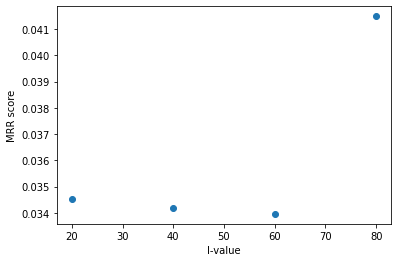

In [15]:
plt.scatter(l_table, MRR_list_a, marker='o');
plt.xlabel('l-value')
plt.ylabel('MRR score')
plt.show()

#### Part III (b) Report an MRR plot with a varying hash sizes k=[5,10,15,20].

In [16]:
#III(b)
k_table=[5,10,15,20]
MRR_list_b=[]
for k in k_table:
    MRR_list_b.append(Search_Quality_Evaluation(20,k))
    print("..",k,"%")
MRR_list_b

[0.04191098699580139,
 0.04214074966751875,
 0.03435771035121949,
 0.036852166888401976]

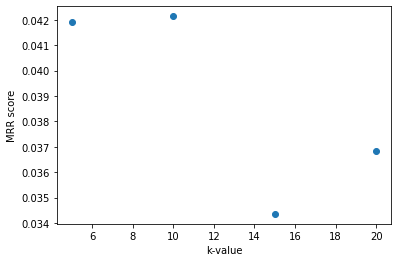

In [17]:
plt.scatter(k_table, MRR_list_b, marker='o');
plt.xlabel('k-value')
plt.ylabel('MRR score')
plt.show()

#### Part III (c) Explain how would you tune the number of tables (l) and the hash size (k) to achieve better MRR.


In [6]:
Search_Quality_Evaluation(80,5)

0.03504815198564393

From partIII-(a), we can easily observe from the graph that as L increases, the mean reciprocal rank (MRR) decreases, but when L=80, the accuracy of MRR increases dramatically. This indicates that the trend of MRR accuracy decreases as L increases. Thus in partIII-(a), the accuracy of MRR is highest at L=80.

Similarly, from partIII-(b), we can observe that the value of the mean reciprocal rank (MRR) tends to decrease as the K value increases. Although the MRR precision tends to increase when k=20, it remains first when k=5. Therefore, we believe that the smaller k is, the higher the MRR precision.

According to part III(a), the MRR is highest when l=60,k=5, while it is highest when l=20,k=5. Therefore we can speculate on the following values of l and k. In summary, when l=60 and k=5 is when MRR is likely to be optimal. After our tests the  possible MRR accury is 3.5%. 